### Transfer Learning and Hyperparameter Tuning with InceptionV3 using Adam

In [1]:
! pip install tensorflow
! pip install matplotlib
! pip install numpy
! pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 13.7 MB/s 
     |████████████████████████████████| 1.6 MB 37.8 MB/s 


In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!ls "/content/drive/My Drive/data/FMD/image"

fabric	foliage  glass	leather  metal	paper  plastic	stone  water  wood


In [4]:
!ls "/content/drive/My Drive/data/FMD/test"

fabric	foliage  glass	leather  metal	paper  plastic	stone  water  wood


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

Data download and preprocessing

In [6]:
materials = ['fabric','foliage','glass','leather','metal','paper','plastic','stone','water','wood']
path_to_folder = "/content/drive/My Drive/data/FMD/image/"

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=path_to_folder,
    labels='inferred',
    label_mode='categorical',
    class_names=materials,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.3,
    subset='training'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=path_to_folder,
    labels='inferred',
    label_mode='categorical',
    class_names=materials,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.3,
    subset='validation'
)

Found 2000 files belonging to 10 classes.
Using 1400 files for training.
Found 2000 files belonging to 10 classes.
Using 600 files for validation.


In [7]:
train_dataset.class_names

['fabric',
 'foliage',
 'glass',
 'leather',
 'metal',
 'paper',
 'plastic',
 'stone',
 'water',
 'wood']

In [8]:
# get test dataset
path_to_test = "/content/drive/My Drive/data/FMD/test"
test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=path_to_test,
    labels='inferred',
    label_mode='categorical',
    class_names=materials,
    batch_size=4,
    image_size=IMG_SIZE,
    shuffle=False,
    seed=42,
    validation_split=None
)

Found 30 files belonging to 10 classes.


In [9]:
# configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [10]:
# data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

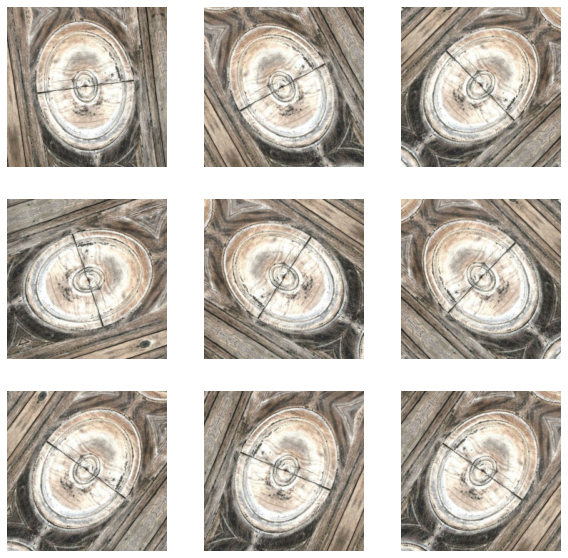

In [11]:
# visualise some of the FMD data
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [12]:
# rescale pixel values for input into model
# InceptionV3 expects [-1, 1]

# To rescale an input in the [0, 255] range to be in the [0, 1] range, you would pass scale=1./255.
# o rescale an input in the [0, 255] range to be in the [-1, 1] range, you would pass scale=1./127.5, offset=-1.

rescale = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)

Hyperparameter tuning using the base HyperModel class

In [13]:
# Create the base model from the pre-trained model Inception V3
IMG_SHAPE = IMG_SIZE + (3,)
base_inceptionv3 = tf.keras.applications.InceptionV3(
    include_top=False, # for transfer learning, set to False
    weights='imagenet',
    input_shape=IMG_SHAPE,
)

87910968/87910968 [==============================] - 5s 0us/step


In [14]:
# Freeze convolutional base to use as a feature extractor
base_inceptionv3.trainable = False

In [15]:
# Let's take a look at the base model architecture
base_inceptionv3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [16]:
# To generate predictions from the block of features,
# average over the spatial 3x3 spatial locations using GlobalAveragePooling2D
# to convert features to a single 2048-element vector per image
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_inceptionv3(image_batch)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [17]:
# Apply Dense layer to convert features into a single prediction per image
prediction_layer = tf.keras.layers.Dense(10) # 10 classes
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


Define the hypermodel

In [18]:
def model_builder(hp):
    
    hp_units = hp.Choice('units', [16, 32, 64, 128, 256, 512, 1024])
    hp_lr = hp.Choice('lr', [1e-2, 1e-3, 1e-4])
    hp_ratio1 = hp.Choice('ratio1', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
    hp_ratio2 = hp.Choice('ratio2', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
    hp_activation = hp.Choice('activation', ['relu', 'elu'])

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = rescale(x)
    x = base_inceptionv3(x, training=False) # set training=False due to BatchNormalization layer
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(hp_ratio1)(x)
    x = tf.keras.layers.Dense(units=hp_units, activation=hp_activation)(x)
    x = tf.keras.layers.Dropout(hp_ratio2)(x)
    outputs = tf.keras.layers.Dense(10)(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model

Instantiate the tuner and perform hypertuning

In [19]:
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=15,
    directory="/content/drive/My Drive/data/FMD/",
    project_name='inceptionv3_hp_adam'
)

In [20]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [21]:
tuner.search(train_dataset, epochs=50,validation_data=validation_dataset, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 02m 18s]
val_accuracy: 0.7883333563804626

Best val_accuracy So Far: 0.7883333563804626
Total elapsed time: 00h 32m 52s


In [22]:
print(best_hps.get('units'))
print(best_hps.get('lr'))
print(best_hps.get('ratio1'))
print(best_hps.get('ratio2'))
print(best_hps.get('activation'))

1024
0.001
0.6
0.1
elu


Train the model with the optimal hyperparameters

In [23]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/My Drive/data/FMD/saved_models/inception_adam/best_inception_adam_hypertune_gan.h5",
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    mode="max",
    save_weights_only=False, # save the whole model,
    save_freq="epoch"
)

In [24]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=[stop_early, model_checkpoint_callback])

Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 2.7995 - accuracy: 0.4450
Epoch 1: val_accuracy improved from -inf to 0.64833, saving model to /content/drive/My Drive/data/FMD/saved_models/inception_adam/best_inception_adam_hypertune_gan.h5
44/44 [==============================] - 14s 218ms/step - loss: 2.7995 - accuracy: 0.4450 - val_loss: 1.0665 - val_accuracy: 0.6483
Epoch 2/50
44/44 [==============================] - ETA: 0s - loss: 1.2183 - accuracy: 0.6179
Epoch 2: val_accuracy improved from 0.64833 to 0.71667, saving model to /content/drive/My Drive/data/FMD/saved_models/inception_adam/best_inception_adam_hypertune_gan.h5
44/44 [==============================] - 8s 175ms/step - loss: 1.2183 - accuracy: 0.6179 - val_loss: 0.8112 - val_accuracy: 0.7167
Epoch 3/50
44/44 [==============================] - ETA: 0s - loss: 1.1257 - accuracy: 0.6421
Epoch 3: val_accuracy did not improve from 0.71667
44/44 [==============================] - 7s 156ms/step - loss: 1.12

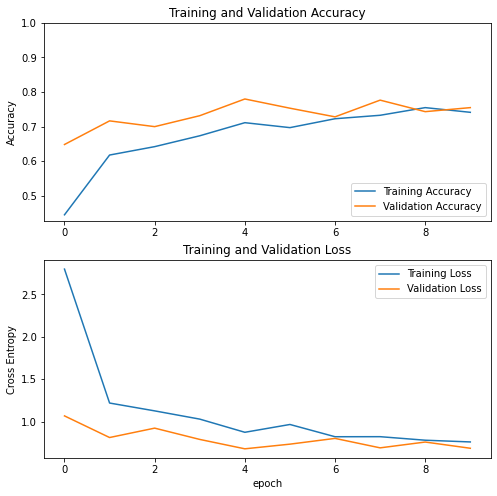

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 5


In [27]:
# Re-instate the hypermodel and train it with the optimal number of epochs
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_dataset, epochs=best_epoch, validation_data=validation_dataset)

Epoch 1/5
44/44 [==============================] - 13s 183ms/step - loss: 2.6470 - accuracy: 0.4014 - val_loss: 0.9936 - val_accuracy: 0.6567
Epoch 2/5
44/44 [==============================] - 7s 153ms/step - loss: 1.2080 - accuracy: 0.6279 - val_loss: 1.0845 - val_accuracy: 0.6383
Epoch 3/5
44/44 [==============================] - 7s 154ms/step - loss: 1.0662 - accuracy: 0.6600 - val_loss: 0.9188 - val_accuracy: 0.7033
Epoch 4/5
44/44 [==============================] - 7s 155ms/step - loss: 0.9468 - accuracy: 0.6979 - val_loss: 1.0327 - val_accuracy: 0.6283
Epoch 5/5
44/44 [==============================] - 7s 156ms/step - loss: 0.9811 - accuracy: 0.6936 - val_loss: 0.8288 - val_accuracy: 0.7283


In [28]:
eval_result = hypermodel.evaluate(test_dataset)
print("[test loss, test accuracy]:", eval_result)

8/8 [==============================] - 13s 1s/step - loss: 1.1210 - accuracy: 0.6333
[test loss, test accuracy]: [1.1209567785263062, 0.6333333253860474]


Continue to do hypertuning for fine-tuning of the base model

In [29]:
# unfreeze top layers of the model
base_inceptionv3.trainable = True

In [30]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_inceptionv3.layers))

Number of layers in the base model:  311


In [31]:
def model_builder_finetune(hp):
    
    # Fine-tune from this layer onwards
    hp_fine_tune_at = hp.Int('fine_tune_at', min_value=250, max_value=300, step=10)
    hp_lr = hp.Choice('lr_fine_tune', [1e-2, 1e-3, 1e-4])

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_inceptionv3.layers[:hp_fine_tune_at]:
      layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model

In [32]:
tuner_finetune = kt.Hyperband(
    model_builder_finetune,
    objective='val_accuracy',
    max_epochs=20,
    directory="/content/drive/My Drive/data/FMD/",
    project_name='inceptionv3_hp_adam_ft'
)

In [33]:
tuner_finetune.search(train_dataset, 
             epochs=50,
            #  initial_epoch=history.epoch[-1],
             validation_data=validation_dataset, 
             callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner_finetune.get_best_hyperparameters(num_trials=1)[0]

Trial 23 Complete [00h 01m 59s]
val_accuracy: 0.8816666603088379

Best val_accuracy So Far: 0.8933333158493042
Total elapsed time: 00h 38m 09s


In [34]:
print(best_hps.get('fine_tune_at'))
print(best_hps.get('lr_fine_tune'))

270
0.001


In [35]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner_finetune.hypermodel.build(best_hps)
initial_epochs = history.epoch[-1]
ft_epochs = 50
total_epochs = initial_epochs + ft_epochs
history_fine = model.fit(train_dataset, epochs=total_epochs, initial_epoch=history.epoch[-1],validation_data=validation_dataset, callbacks=[stop_early, model_checkpoint_callback])

Epoch 10/59
44/44 [==============================] - ETA: 0s - loss: 1.0537 - accuracy: 0.9800
Epoch 10: val_accuracy improved from 0.78000 to 0.87000, saving model to /content/drive/My Drive/data/FMD/saved_models/inception_adam/best_inception_adam_hypertune_gan.h5
44/44 [==============================] - 16s 261ms/step - loss: 1.0537 - accuracy: 0.9800 - val_loss: 12.3597 - val_accuracy: 0.8700
Epoch 11/59
44/44 [==============================] - ETA: 0s - loss: 1.3888 - accuracy: 0.9814
Epoch 11: val_accuracy improved from 0.87000 to 0.87833, saving model to /content/drive/My Drive/data/FMD/saved_models/inception_adam/best_inception_adam_hypertune_gan.h5
44/44 [==============================] - 9s 201ms/step - loss: 1.3888 - accuracy: 0.9814 - val_loss: 11.3353 - val_accuracy: 0.8783
Epoch 12/59
44/44 [==============================] - ETA: 0s - loss: 1.5119 - accuracy: 0.9757
Epoch 12: val_accuracy did not improve from 0.87833
44/44 [==============================] - 8s 165ms/step -

In [36]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

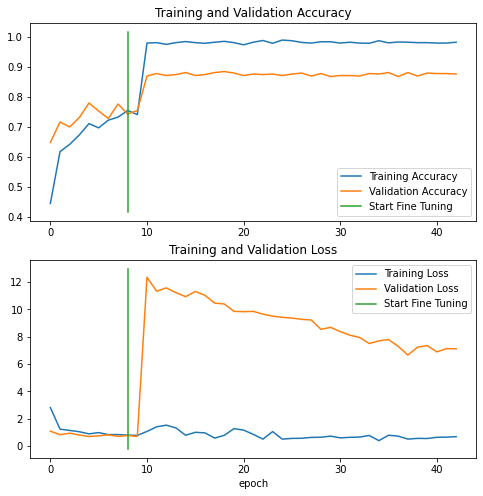

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [38]:
val_acc_per_epoch_ft = history_fine.history['val_accuracy']
best_epoch_ft = val_acc_per_epoch_ft.index(max(val_acc_per_epoch_ft)) + 1
print('Best epoch: %d' % (best_epoch_ft,))

Best epoch: 9


In [39]:
# Re-instate the hypermodel and train it with the optimal number of epochs
hypermodel_ft = tuner_finetune.hypermodel.build(best_hps)

# Retrain the model
hypermodel_ft.fit(train_dataset, epochs=best_epoch, validation_data=validation_dataset)

Epoch 1/5
44/44 [==============================] - 13s 184ms/step - loss: 0.3577 - accuracy: 0.9857 - val_loss: 7.1346 - val_accuracy: 0.8750
Epoch 2/5
44/44 [==============================] - 7s 156ms/step - loss: 0.5679 - accuracy: 0.9814 - val_loss: 6.9237 - val_accuracy: 0.8833
Epoch 3/5
44/44 [==============================] - 7s 155ms/step - loss: 0.5151 - accuracy: 0.9829 - val_loss: 6.8183 - val_accuracy: 0.8817
Epoch 4/5
44/44 [==============================] - 8s 159ms/step - loss: 0.6059 - accuracy: 0.9793 - val_loss: 7.0130 - val_accuracy: 0.8767
Epoch 5/5
44/44 [==============================] - 7s 157ms/step - loss: 0.4215 - accuracy: 0.9850 - val_loss: 6.5089 - val_accuracy: 0.8800


In [40]:
eval_result_ft = hypermodel_ft.evaluate(test_dataset)
print("[test loss, test accuracy]:", eval_result_ft)

8/8 [==============================] - 3s 330ms/step - loss: 34.1697 - accuracy: 0.6000
[test loss, test accuracy]: [34.1696662902832, 0.6000000238418579]


In [41]:
saved_inception_adam = tf.keras.models.load_model("/content/drive/My Drive/data/FMD/saved_models/inception_adam/best_inception_adam_hypertune_gan.h5")

In [42]:
eval = saved_inception_adam.evaluate(test_dataset)
print("[test loss, test accuracy]:", eval)

8/8 [==============================] - 4s 315ms/step - loss: 50.9016 - accuracy: 0.6333
[test loss, test accuracy]: [50.90164566040039, 0.6333333253860474]
